In [58]:
import json
import os
import numpy as np
from catboost import Pool, CatBoostClassifier
from catboost.utils import read_cd
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
import joblib
from collections import defaultdict
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt

In [ ]:
def create_dir(name):
    directory = os.path.dirname(name)
    if not os.path.exists(name):
        os.makedirs(name)

In [ ]:
def tune_parameters_classification(dataset_name, alg='sgb'):

    # load and prepare data
    data_dir = os.path.join('datasets', dataset_name)
    train_file = os.path.join(data_dir, 'train')
    validation_file = os.path.join(data_dir, 'validation')
    cd_file = os.path.join(data_dir, 'pool.cd')
    
    train_pool = Pool(data=train_file, column_description=cd_file)
    validation_pool = Pool(data=validation_file, column_description=cd_file)    

    seed = 1000 # starting random seed for hyperparameter tuning
    
    # list of hyperparameters for grid search
    depths = [3, 4, 5, 6] # tree depth
    lrs = [0.001, 0.01, 0.1] # learning rate 
    
    if alg == "sgb" or alg == "sglb": # by default, we tune sample rate
        samples = [0.25, 0.5, 0.75]
    if alg == "sgb-fixed": # sgb without sample rate tuning
        samples = [0.5]
    if alg == "sglb-fixed": # sglb without sample rate tuning
        samples = [1.0]
    shape = (len(depths), len(lrs), len(samples))

    results = np.zeros(shape)
    
    # perform grid search
    for d, depth in enumerate(depths):
        for l, lr in enumerate(lrs):
            for s, sample in enumerate(samples):
                if alg == 'sgb' or alg == 'sgb-fixed':
                    model = CatBoostClassifier(loss_function='Logloss',learning_rate=lr, depth=depth, subsample=sample, bootstrap_type='Bernoulli', verbose=False, random_seed=seed)                      
                if alg == 'sglb' or alg == 'sglb-fixed':
                    model = CatBoostClassifier(loss_function='Logloss',learning_rate=lr, depth=depth, subsample=sample, bootstrap_type='Bernoulli', verbose=False, random_seed=seed, posterior_sampling=True)
                    
                model.fit(train_pool, eval_set=validation_pool, use_best_model=False)
                results[d, l, s] = model.evals_result_['validation']['Logloss'][-1]
                    
                seed += 1 # update seed
        
    # get best parameters
    argmin = np.unravel_index(np.argmin(results), shape)
    depth = depths[argmin[0]]
    lr = lrs[argmin[1]]
    sample = samples[argmin[2]]
        
    params = {'depth': depth, 'lr': lr, 'sample': sample}
    
    return params

In [ ]:
def generate_ensemble_classification(dataset_name, params, alg="sgb", num_models=10):

    # load and prepare data
    data_dir = os.path.join('datasets', dataset_name)
    full_train_file = os.path.join(data_dir, 'full_train')
    test_file = os.path.join(data_dir, 'test')
    cd_file = os.path.join(data_dir, 'pool.cd')
    
    full_train_pool = Pool(data=full_train_file, column_description=cd_file)
    test_pool = Pool(data=test_file, column_description=cd_file)

    # parameters
    depth = params['depth']
    lr = params['lr']
    sample = params['sample']
        
    seed = 0
    for i in range(num_models):
        if alg == 'sgb' or alg == 'sgb-fixed':
            model = CatBoostClassifier(loss_function='Logloss', verbose=False, 
                                       learning_rate=lr, depth=depth, subsample=sample,
                                       bootstrap_type='Bernoulli', custom_metric='ZeroOneLoss', 
                                       random_seed=seed)   
        if alg == 'sglb' or alg == 'sglb-fixed':
            model = CatBoostClassifier(loss_function='Logloss', verbose=False, 
                                       learning_rate=lr, depth=depth, subsample=sample, 
                                       bootstrap_type='Bernoulli', posterior_sampling=True, 
                                       custom_metric='ZeroOneLoss', random_seed=seed)
        seed += 1 # new seed for each ensemble element

        model.fit(full_train_pool, eval_set=test_pool, use_best_model=False) # do not use test pool for choosing best iteration
        model.save_model("results/models/" + dataset_name + "_" + alg + "_" + str(i), format="cbm")

In [ ]:
tuning = 1  # Change to 1 for tuning hyperparameters

datasets = ["credit"] 

algorithms = ['sgb-fixed', 'sglb-fixed'] 

print('Classification - Boosting: Generating models..')
for name in datasets:
    print("Dataset =", name)

    if tuning == 1:
        create_dir("results/params")

        # Tune hyperparameters
        print("Tuning hyperparameters...")
        for alg in algorithms:
            print('Algorithm = ', alg)
            params = tune_parameters_classification(name, alg=alg)
            with open("results/params/" + name + "_" + alg + '.json', 'w') as fp:
                json.dump(params, fp)

    # Training all models
    print("Training models...")
    create_dir("results/models")
    for alg in algorithms:
        print('Algorithm = ', alg)
        with open("results/params/" + name + "_" + alg + '.json', 'r') as fp:
            params = json.load(fp)
        generate_ensemble_classification(name, params, alg=alg)
print('Done!!')

----

In [ ]:
def process_classification_dataset(name):
    # converting categorical features to numerical

    data_dir = os.path.join('datasets', name)
    train_file = os.path.join(data_dir, 'full_train')
    test_file = os.path.join(data_dir, 'test')
    cd_file = os.path.join(data_dir, 'pool.cd')

    train = np.loadtxt(train_file, delimiter="\t", dtype="object")
    test = np.loadtxt(test_file, delimiter="\t", dtype="object")
    cd = read_cd(cd_file, data_file=train_file)

    # Target can be called 'Label' or 'Target' in pool.cd
    try:
        label_ind = cd['column_type_to_indices']['Label']
    except:
        label_ind = cd['column_type_to_indices']['Target']

    np.random.seed(42)  # fix random seed
    train = np.random.permutation(train)

    y_train = train[:, label_ind]
    y_train = y_train.reshape(-1)

    y_test = test[:, label_ind]
    y_test = y_test.reshape(-1)

    cat_features = cd['column_type_to_indices']['Categ']  # features to be replaced

    enc = LeaveOneOutEncoder(cols=cat_features, return_df=False, random_state=10, sigma=0.3)

    transformed_train = enc.fit_transform(train, y_train).astype("float64")
    X_train = np.delete(transformed_train, label_ind, 1)  # remove target column

    transformed_test = enc.transform(test).astype("float64")
    X_test = np.delete(transformed_test, label_ind, 1)  # remove target column

    return np.nan_to_num(X_train), y_train, np.nan_to_num(X_test), y_test, enc

In [41]:
def prr_class(labels, probs, measure, rev: bool):
    # Get predictions
    preds = np.argmax(probs, axis=1)

    if rev:
        inds = np.argsort(measure)[::-1]
    else:
        inds = np.argsort(measure)

    total_data = np.float64(preds.shape[0])
    errors, percentages = [], []

    for i in range(preds.shape[0]):
        errors.append(np.sum(
            np.asarray(labels[inds[:i]] != preds[inds[:i]], dtype=np.float32)) * 100.0 / total_data)
        percentages.append(float(i + 1) / total_data * 100.0)
    errors, percentages = np.asarray(errors)[:, np.newaxis], np.asarray(percentages)

    base_error = errors[-1]
    n_items = errors.shape[0]
    
    auc_uns = 1.0 - auc(percentages / 100.0, errors[::-1] / 100.0)

    random_rejection = np.asarray(
        [base_error * (1.0 - float(i) / float(n_items)) for i in range(n_items)],
        dtype=np.float32)
    auc_rnd = 1.0 - auc(percentages / 100.0, random_rejection / 100.0)
    orc_rejection = np.asarray(
        [base_error * (1.0 - float(i) / float(base_error / 100.0 * n_items)) for i in
         range(int(base_error / 100.0 * n_items))], dtype=np.float32)
    orc = np.zeros_like(errors)
    orc[0:orc_rejection.shape[0]] = orc_rejection
    auc_orc = 1.0 - auc(percentages / 100.0, orc / 100.0)

    rejection_ratio = (auc_uns - auc_rnd) / (auc_orc - auc_rnd) * 100.0
    return rejection_ratio

def ood_detect(domain_labels, in_measure, out_measure, mode, pos_label=1):
    scores = np.concatenate((in_measure, out_measure), axis=0)
    scores = np.asarray(scores, dtype=np.longdouble)
    if pos_label != 1:
        scores *= -1.0

    if mode == 'PR':
        precision, recall, thresholds = precision_recall_curve(domain_labels, scores)
        aupr = auc(recall, precision)
        return aupr

    elif mode == 'ROC':
        roc_auc = roc_auc_score(domain_labels, scores)
        return roc_auc

def nll_class(target, probs, epsilon=1e-10):
    log_p = -np.log(probs + epsilon)
    return target*log_p[:, 1] + (1-target)*log_p[:, 0]

def plot_roc_curve(y_true, predictions, title):
    y_test_digits = [int(digit) for digit in y_true]
    preds_digits = [int(digit) for digit in predictions]
    fpr, tpr, _ = metrics.roc_curve(y_test_digits, preds_digits, pos_label=1)
    roc_auc = metrics.roc_auc_score(y_test_digits, preds_digits)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k')
    plt.plot(fpr, tpr, label='Area = ' + str(roc_auc))
    plt.xlabel('False Positive')
    plt.ylabel('True Positive')
    plt.title('ROC curve for ' + title)
    plt.legend(loc='best')
    plt.show()

In [ ]:
def entropy(probs, epsilon=1e-10):
    log_probs = -np.log(probs + epsilon)
    return np.sum(probs * log_probs, axis=1)

def entropy_of_expected_class(probs, epsilon=1e-10):
    mean_probs = np.mean(probs, axis=0)
    log_probs = -np.log(mean_probs + epsilon)
    return np.sum(mean_probs * log_probs, axis=1)


def expected_entropy_class(probs, epsilon=1e-10):
    log_probs = -np.log(probs + epsilon)

    return np.mean(np.sum(probs * log_probs, axis=2), axis=0)

In [42]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))
     
def load_model(name, alg, i):
    if alg == "rf":
        model = joblib.load("results/models/" + name + "_" + alg + "_" + str(i))
    else:
        model = CatBoostClassifier()
        model.load_model("results/models/" + name + "_" + alg + "_" + str(i)) 
    return model

def normalize_test_labels(y_test):
    y_test_norm = []
    c0 = min(y_test)
    for y in y_test:
        if y == c0:
            y_test_norm.append(0)
        else:
            y_test_norm.append(1)
    return np.array(y_test_norm)
            
def aggregate_results(name, modes = ["single", "ens"], algorithms = ['sgb-fixed', 'sglb-fixed'], num_models = 10):
    
    results = [] # metric values for all algorithms and all folds
        
    for mode in modes:
        for alg in algorithms:
            
            test_pool = Pool(data="datasets/"+name+"/test", column_description="datasets/"+name+"/pool.cd")
            ood_test_pool = Pool(data="datasets/ood/" + name, column_description="datasets/"+name+"/pool.cd")
            ood_size = ood_test_pool.num_row()

            y_test = test_pool.get_label()
            
            test_size = len(y_test)
            domain_labels = np.concatenate([np.zeros(test_size), np.ones(ood_size)])
                    
            y_test_norm = normalize_test_labels(y_test)
        
            values = defaultdict() # metric values for all folds for given algorithm

            if mode == "single":
                # use 0th model from ensemble as a single model
                model = load_model(name, alg, 0)
                preds = model.predict(test_pool)
                preds_proba = model.predict_proba(test_pool)
                plot_roc_curve(test_pool.get_label(), preds.tolist(), 'single ' + alg)
                values["error"] = (preds != y_test).astype(int)
                values["nll"] = nll_class(y_test_norm, preds_proba)
                values["TU_prr"] = prr_class(y_test_norm, preds_proba, entropy(preds_proba), False)
                values["KU_prr"] = float("nan")
                values["KU_auc"] = float("nan")
                    
                ood_preds_proba = model.predict_proba(ood_test_pool)
                in_measure = entropy(preds_proba)
                out_measure = entropy(ood_preds_proba)
                values["TU_auc"] = ood_detect(domain_labels, in_measure, out_measure, mode="ROC")

            if mode == "ens":
                all_preds = [] # predictions of all models in ensemble
                all_preds_ood = []
                    
                for i in range(num_models):
                    model = load_model(name, alg, i)
                    preds = model.predict_proba(test_pool)
                    all_preds.append(preds)
                    preds = model.predict_proba(ood_test_pool)
                    all_preds_ood.append(preds)
                plot_roc_curve(test_pool.get_label(), model.predict(test_pool).tolist(), 'ensemble ' + alg)
                        
                all_preds = np.array(all_preds)
                preds_proba = np.mean(all_preds, axis=0)
                
                all_preds_ood = np.array(all_preds_ood)
                
                preds = np.argmax(preds_proba, axis=1)
                values["error"] = (preds != y_test_norm).astype(int)
                values["nll"] = nll_class(y_test_norm, preds_proba)
                
                TU = entropy_of_expected_class(all_preds)
                DU = expected_entropy_class(all_preds)
                KU = TU - DU
                
                TU_ood = entropy_of_expected_class(all_preds_ood)
                DU_ood = expected_entropy_class(all_preds_ood)
                KU_ood = TU_ood - DU_ood

                values["TU_prr"] = prr_class(y_test_norm, preds_proba, TU, False)
                values["KU_prr"] = prr_class(y_test_norm, preds_proba, KU, False)
                  
                values["TU_auc"] = ood_detect(domain_labels, TU, TU_ood, mode="ROC")
                values["KU_auc"] = ood_detect(domain_labels, KU, KU_ood, mode="ROC")
                        
            results.append(values)

    return np.array(results)
    
def make_table(values):
    prr_TU = np.array([values[i]["TU_prr"] for i in range(len(values))])
    auc_TU = np.array([values[i]["TU_auc"] for i in range(len(values))])
    TU = np.concatenate((prr_TU, 100*auc_TU), axis=0)

    prr_KU = np.array([values[i]["KU_prr"] for i in range(len(values))])
    auc_KU = np.array([values[i]["KU_auc"] for i in range(len(values))])
    KU = np.concatenate((prr_KU, 100*auc_KU), axis=0)

    df = pd.DataFrame(np.stack((TU, KU)), index=['TU', 'KU']) 
    columns=[('PRR%', 'Single','SGB'),('PRR%', 'Single','SGLB'), ('PRR%', 'Ensemble','SGB'),('PRR%', 'Ensemble','SGLB'), 
             ('AUC-ROC%', 'Single','SGB'),('AUC-ROC%', 'Single','SGLB'), ('AUC-ROC%', 'Ensemble','SGB'),('AUC-ROC%', 'Ensemble','SGLB')]
    df.columns=pd.MultiIndex.from_tuples(columns)
    return df

			Classification - Boosting
			===PRR and AUC-ROC Table===


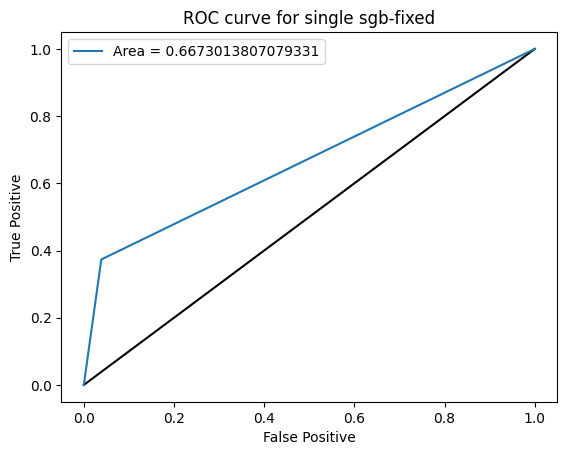

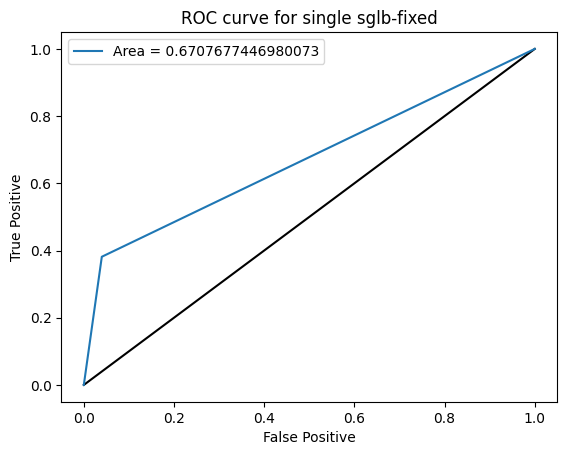

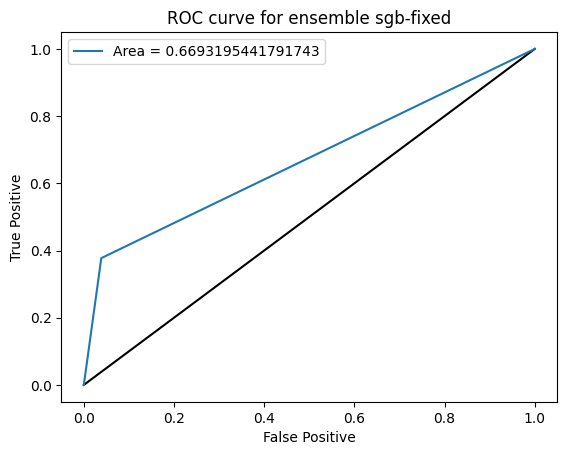

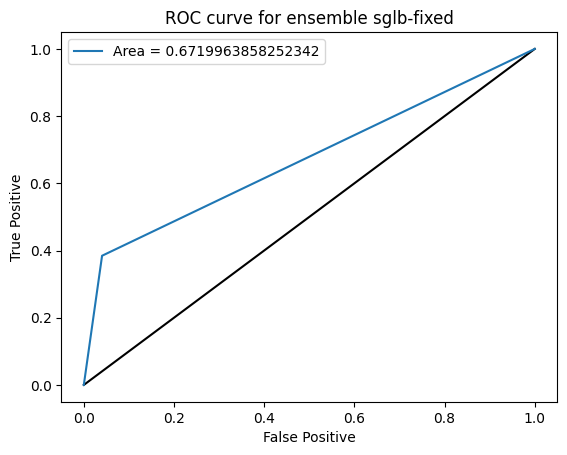

PRR%                                   AUC-ROC%                       \
       Single              Ensemble               Single             Ensemble   
          SGB       SGLB        SGB       SGLB       SGB      SGLB        SGB   
TU  45.305925  46.238564  45.501887  45.858059  78.47836  75.49434  79.607265   
KU        NaN        NaN  19.732223  18.123800       NaN       NaN  99.087251   

               
               
         SGLB  
TU  75.308638  
KU  99.484801

In [43]:
dataset = "credit"
print('\t\t\tClassification - Boosting')
print("\t\t\t===PRR and AUC-ROC Table===")

values = aggregate_results(dataset)

make_table(values)